# Exposure Risk Estimation - One Year Horizon

This notebook generates forward-looking risk estimates for all exposures in the universe with a one-year forecast horizon, using optimally validated parameters.

## Contents
1. Load exposure universe and setup
2. Generate one-year risk estimates for all exposures
3. Visualize volatility estimates
4. Analyze correlation structure
5. Create risk reports and heatmaps
6. Export results for portfolio optimization

## 1. Setup and Load Exposure Universe

In [1]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Import portfolio optimizer classes
from data.exposure_universe import ExposureUniverse
from optimization.exposure_risk_estimator import ExposureRiskEstimator
from optimization.parameter_optimization import ParameterOptimizer

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.precision', 4)
pd.set_option('display.max_columns', None)

In [2]:
# Load exposure universe
universe_path = Path.cwd().parent / 'config' / 'exposure_universe.yaml'
universe = ExposureUniverse.from_yaml(str(universe_path))

print(f"Loaded {len(universe)} exposures")
print("\nExposure categories:")
categories = {}
for exp_id, exposure in universe.exposures.items():
    cat = exposure.category
    if cat not in categories:
        categories[cat] = []
    categories[cat].append(exp_id)

for cat, exposures in categories.items():
    print(f"\n{cat}:")
    for exp in exposures:
        print(f"  - {exp}")

Loaded 16 exposures

Exposure categories:

equity_beta:
  - us_large_equity
  - us_small_equity
  - intl_developed_large_equity
  - intl_developed_small_equity
  - emerging_equity

factor_style:
  - factor_style_equity
  - factor_style_other

alternatives:
  - trend_following

nominal_fixed_income:
  - cash_rate
  - short_ust
  - broad_ust
  - dynamic_global_bonds

real_assets:
  - real_estate
  - commodities
  - gold
  - tips


## 2. Generate One-Year Risk Estimates

In [3]:
# Initialize risk estimator
risk_estimator = ExposureRiskEstimator(universe)

# Set parameters for one-year horizon
estimation_date = datetime.now()
forecast_horizon = 252  # One year in trading days
lookback_days = 1260    # 5 years of history

# Get all implementable exposures
all_exposures = []
for exp_id, exposure in universe.exposures.items():
    impl = exposure.get_preferred_implementation()
    if impl and impl.get_primary_tickers():
        all_exposures.append(exp_id)

print(f"Found {len(all_exposures)} implementable exposures")
print(f"Estimation date: {estimation_date.strftime('%Y-%m-%d')}")
print(f"Forecast horizon: {forecast_horizon} days (1 year)")
print(f"Historical lookback: {lookback_days} days ({lookback_days/252:.1f} years)")

Found 15 implementable exposures
Estimation date: 2025-07-07
Forecast horizon: 252 days (1 year)
Historical lookback: 1260 days (5.0 years)


In [4]:
# Generate risk estimates using optimal parameters
print("Generating one-year risk estimates...")
print("This may take a few minutes for all exposures.")

try:
    # Get complete risk matrix
    risk_matrix = risk_estimator.get_risk_matrix(
        exposures=all_exposures,
        estimation_date=estimation_date,
        forecast_horizon=forecast_horizon,
        method='optimal'  # Uses validated parameters
    )
    
    print(f"\n✅ Successfully generated risk estimates for {len(risk_matrix.exposures)} exposures")
    
except Exception as e:
    print(f"\n❌ Error generating risk matrix: {e}")
    print("\nTrying with reduced exposure set...")
    
    # Fallback: try with core exposures only
    core_exposures = [
        'us_large_equity', 'us_small_equity', 
        'intl_developed_large_equity', 'emerging_markets_equity',
        'us_treasury_long', 'us_treasury_short',
        'commodities_broad', 'real_estate_us'
    ]
    
    available_core = [exp for exp in core_exposures if exp in all_exposures]
    
    risk_matrix = risk_estimator.get_risk_matrix(
        exposures=available_core,
        estimation_date=estimation_date,
        forecast_horizon=forecast_horizon,
        method='optimal'
    )
    
    print(f"\n✅ Generated risk estimates for {len(risk_matrix.exposures)} core exposures")

Generating one-year risk estimates...
This may take a few minutes for all exposures.


Removing 2 outliers from SPY
Removing 2 outliers from IVV
Removing 2 outliers from VOO
Removing 1 outliers from IWM
Removing 2 outliers from IJR
Removing 2 outliers from VB
Removing 2 outliers from EFA
Removing 2 outliers from IEFA
Removing 2 outliers from VEA
Removing 2 outliers from SCZ
Removing 2 outliers from IEUS
Removing 2 outliers from VSS
Removing 2 outliers from EEM
Removing 2 outliers from IEMG
Removing 2 outliers from VWO
High number of zero returns in QMNIX: 58
Removing 1 outliers from QSPIX
Unsupported implementation type fund_average for trend_following
Insufficient data for trend_following: 0 periods
Failed to estimate risk for exposure trend_following
High number of zero returns in SCHO: 59
Removing 2 outliers from GOVT
High number of zero returns in PFIUX: 167
Removing 1 outliers from VNQ
Removing 1 outliers from XLRE
Removing 1 outliers from RWR
Removing 1 outliers from REET



✅ Successfully generated risk estimates for 14 exposures


## 3. Volatility Analysis

In [5]:
# Extract and display volatilities
volatilities = risk_matrix.volatilities.sort_values(ascending=False)

print("One-Year Volatility Forecasts (Annualized)")
print("="*50)
for exp_id, vol in volatilities.items():
    exposure = universe.get_exposure(exp_id)
    print(f"{exposure.name:40s}: {vol:6.2%}")

One-Year Volatility Forecasts (Annualized)
Broad Commodities                       : 18.71%
US Small Cap Equity Beta                : 18.02%
Gold                                    : 17.97%
Emerging Markets Equity Beta            : 14.30%
Real Estate                             : 13.79%
US Large Cap Equity Beta                : 12.71%
Developed Ex-US Large Cap Equity Beta   : 12.11%
Developed Ex-US Small Cap Equity Beta   : 12.01%
Factor/Style - Other                    :  7.93%
Factor/Style - Equities                 :  6.92%
Broad US Treasuries                     :  4.52%
Dynamic Global Bonds                    :  3.54%
Treasury Inflation-Protected Securities :  3.14%
Short-Term US Treasuries                :  1.38%


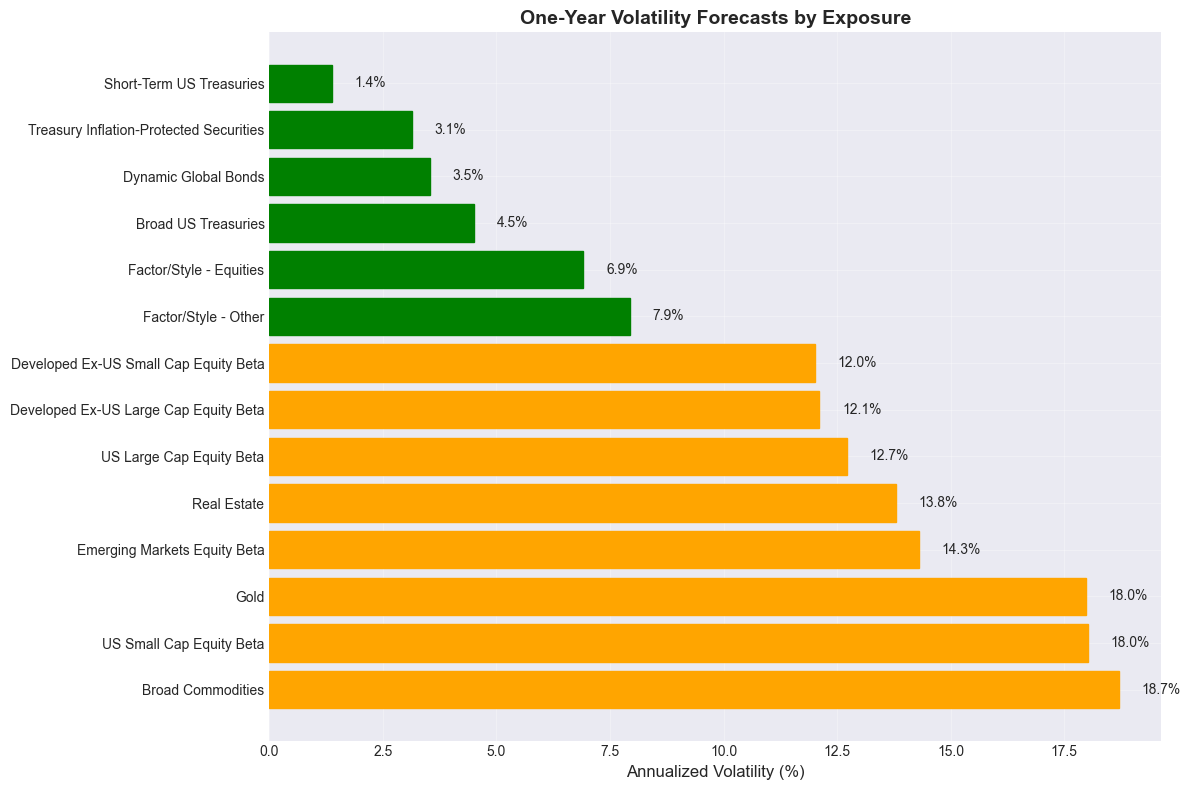

In [6]:
# Volatility bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data
vol_df = pd.DataFrame({
    'Exposure': [universe.get_exposure(exp).name for exp in volatilities.index],
    'Volatility': volatilities.values * 100  # Convert to percentage
})

# Create bar chart
bars = ax.barh(vol_df['Exposure'], vol_df['Volatility'])

# Color bars by risk level
colors = ['green' if v < 10 else 'orange' if v < 20 else 'red' for v in vol_df['Volatility']]
for bar, color in zip(bars, colors):
    bar.set_color(color)

ax.set_xlabel('Annualized Volatility (%)', fontsize=12)
ax.set_title('One-Year Volatility Forecasts by Exposure', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add value labels
for i, (exp, vol) in enumerate(zip(vol_df['Exposure'], vol_df['Volatility'])):
    ax.text(vol + 0.5, i, f'{vol:.1f}%', va='center')

plt.tight_layout()
plt.show()

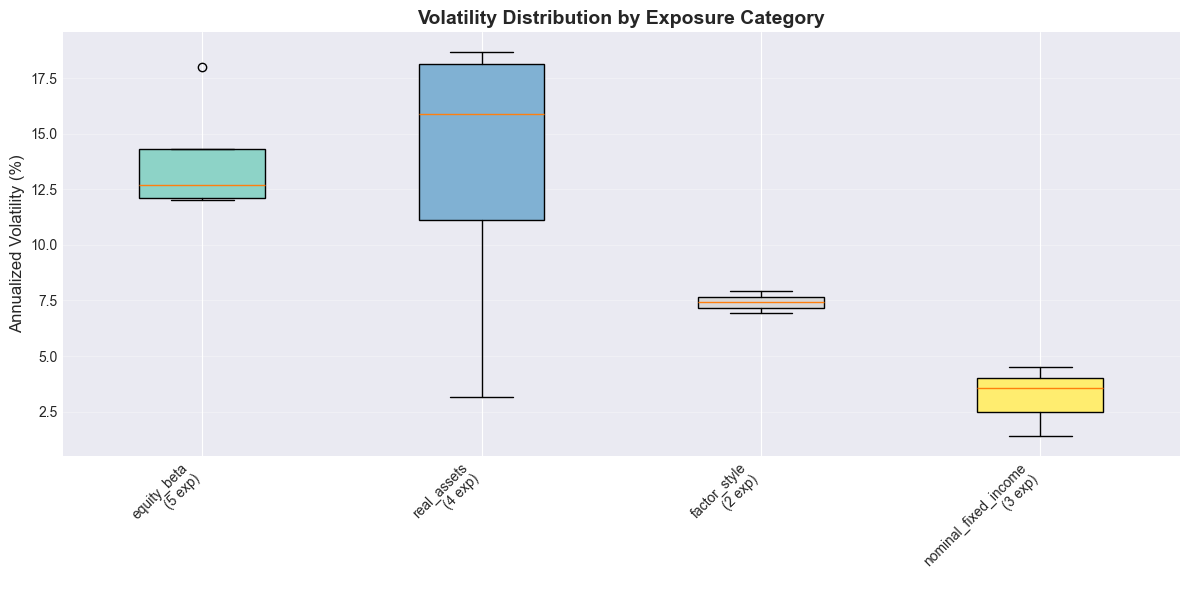

In [7]:
# Volatility by category
category_vols = {}
for exp_id, vol in volatilities.items():
    exposure = universe.get_exposure(exp_id)
    cat = exposure.category
    if cat not in category_vols:
        category_vols[cat] = []
    category_vols[cat].append(vol)

# Calculate average volatility by category
cat_avg_vols = {cat: np.mean(vols) for cat, vols in category_vols.items()}
cat_avg_vols = dict(sorted(cat_avg_vols.items(), key=lambda x: x[1], reverse=True))

# Create box plot
fig, ax = plt.subplots(figsize=(12, 6))

data_for_plot = []
labels = []
for cat in cat_avg_vols.keys():
    data_for_plot.append([v * 100 for v in category_vols[cat]])
    labels.append(f"{cat}\n({len(category_vols[cat])} exp)")

bp = ax.boxplot(data_for_plot, labels=labels, patch_artist=True)

# Color boxes
colors = plt.cm.Set3(np.linspace(0, 1, len(cat_avg_vols)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('Annualized Volatility (%)', fontsize=12)
ax.set_title('Volatility Distribution by Exposure Category', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4. Correlation Analysis

In [8]:
# Extract correlation matrix
correlation_matrix = risk_matrix.correlation_matrix

print(f"Correlation matrix shape: {correlation_matrix.shape}")
print(f"\nCorrelation statistics:")
print(f"  Mean correlation: {correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].mean():.3f}")
print(f"  Median correlation: {np.median(correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)]):.3f}")
print(f"  Max correlation: {correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].max():.3f}")
print(f"  Min correlation: {correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].min():.3f}")

Correlation matrix shape: (14, 14)

Correlation statistics:
  Mean correlation: 0.136
  Median correlation: 0.029
  Max correlation: 0.943
  Min correlation: -0.453


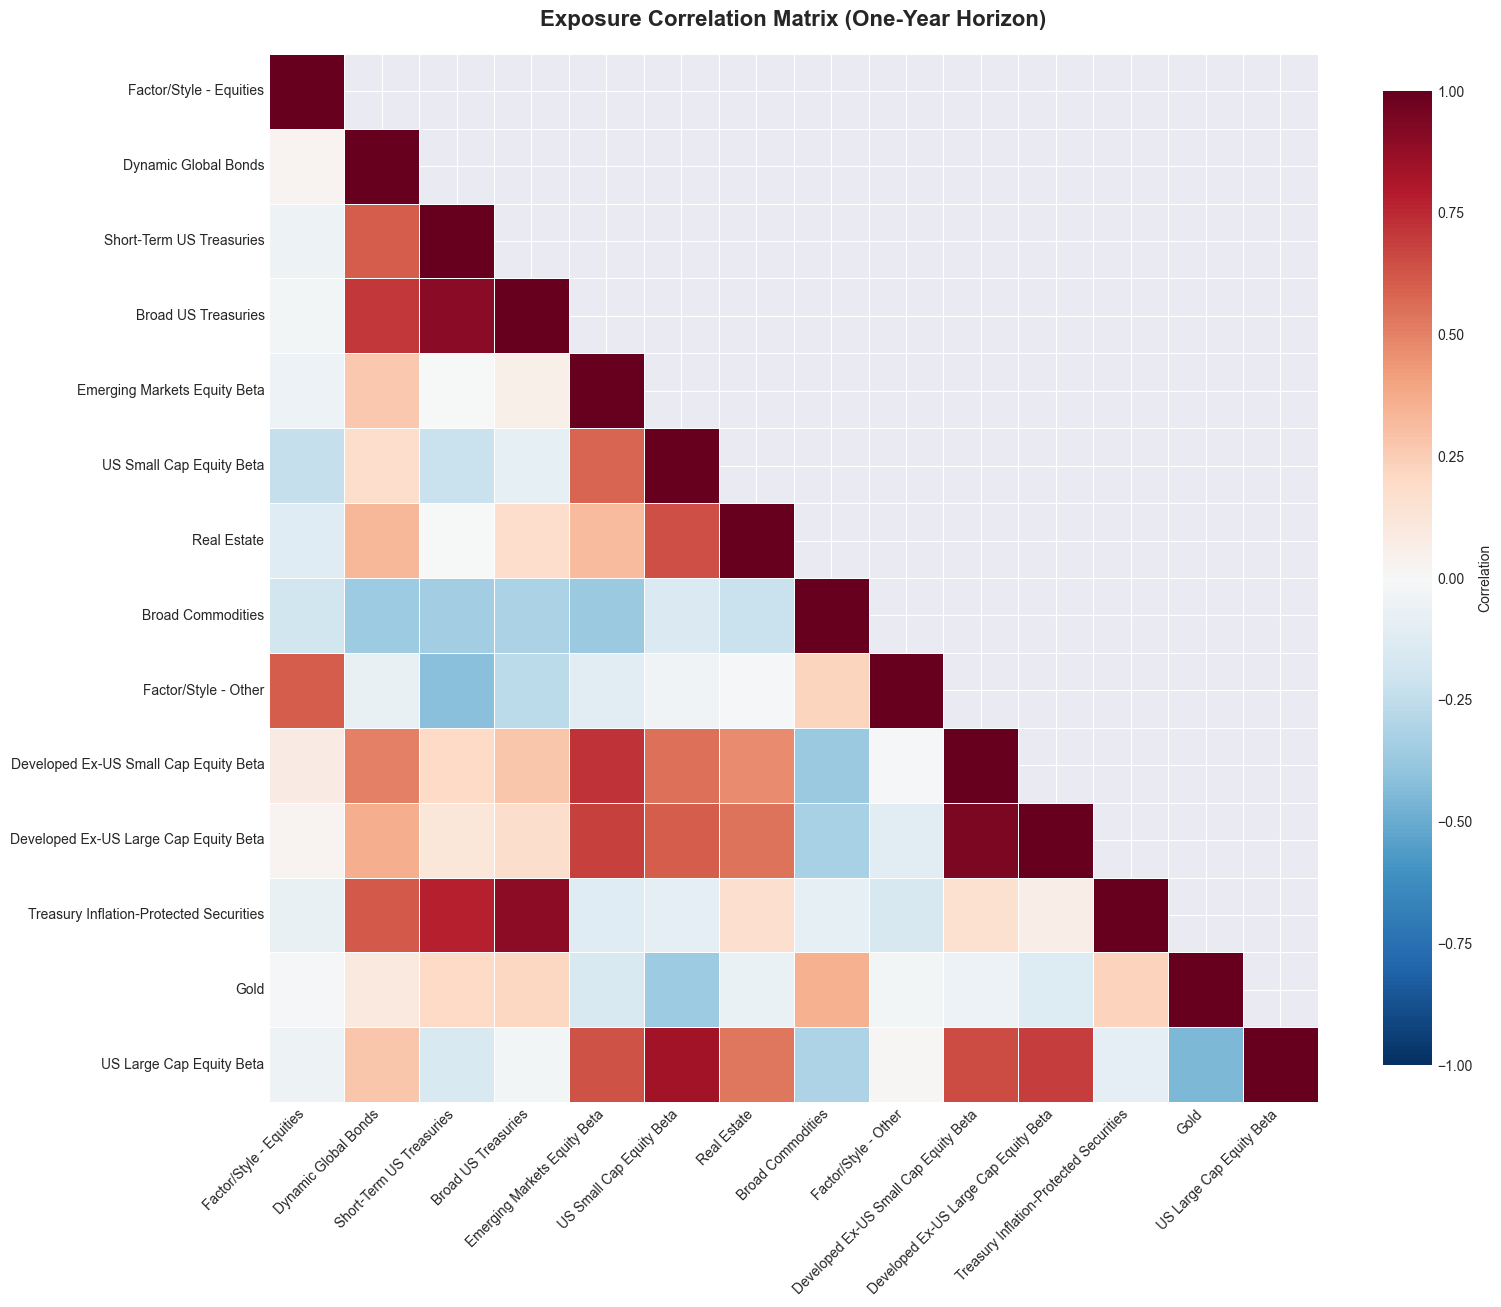

In [9]:
# Create correlation heatmap
plt.figure(figsize=(16, 14))

# Create readable labels
labels = [universe.get_exposure(exp).name for exp in correlation_matrix.index]

# Create heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
sns.heatmap(
    correlation_matrix,
    mask=mask,
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Correlation"},
    xticklabels=labels,
    yticklabels=labels
)

plt.title('Exposure Correlation Matrix (One-Year Horizon)', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [10]:
# Interactive correlation heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=labels,
    y=labels,
    colorscale='RdBu',
    zmid=0,
    zmin=-1,
    zmax=1,
    colorbar=dict(title="Correlation"),
    hoverongaps=False,
    hovertemplate='%{x}<br>%{y}<br>Correlation: %{z:.3f}<extra></extra>'
))

fig.update_layout(
    title='Interactive Correlation Matrix (One-Year Horizon)',
    xaxis=dict(tickangle=45),
    yaxis=dict(autorange='reversed'),
    width=1000,
    height=900
)

fig.show()

In [11]:
# Find most and least correlated exposure pairs
corr_values = correlation_matrix.values
n = len(correlation_matrix)

# Extract upper triangle (excluding diagonal)
correlations = []
for i in range(n):
    for j in range(i+1, n):
        correlations.append({
            'Exposure1': correlation_matrix.index[i],
            'Exposure2': correlation_matrix.index[j],
            'Correlation': corr_values[i, j]
        })

corr_df = pd.DataFrame(correlations).sort_values('Correlation', ascending=False)

print("Most Positively Correlated Pairs:")
print("="*60)
for _, row in corr_df.head(10).iterrows():
    exp1_name = universe.get_exposure(row['Exposure1']).name
    exp2_name = universe.get_exposure(row['Exposure2']).name
    print(f"{exp1_name:30s} <-> {exp2_name:30s}: {row['Correlation']:.3f}")

print("\nMost Negatively Correlated Pairs:")
print("="*60)
for _, row in corr_df.tail(10).iterrows():
    exp1_name = universe.get_exposure(row['Exposure1']).name
    exp2_name = universe.get_exposure(row['Exposure2']).name
    print(f"{exp1_name:30s} <-> {exp2_name:30s}: {row['Correlation']:.3f}")

Most Positively Correlated Pairs:
Developed Ex-US Small Cap Equity Beta <-> Developed Ex-US Large Cap Equity Beta: 0.943
Short-Term US Treasuries       <-> Broad US Treasuries           : 0.899
Broad US Treasuries            <-> Treasury Inflation-Protected Securities: 0.895
US Small Cap Equity Beta       <-> US Large Cap Equity Beta      : 0.841
Short-Term US Treasuries       <-> Treasury Inflation-Protected Securities: 0.774
Emerging Markets Equity Beta   <-> Developed Ex-US Small Cap Equity Beta: 0.720
Dynamic Global Bonds           <-> Broad US Treasuries           : 0.709
Developed Ex-US Large Cap Equity Beta <-> US Large Cap Equity Beta      : 0.691
Emerging Markets Equity Beta   <-> Developed Ex-US Large Cap Equity Beta: 0.687
Developed Ex-US Small Cap Equity Beta <-> US Large Cap Equity Beta      : 0.649

Most Negatively Correlated Pairs:
Broad Commodities              <-> US Large Cap Equity Beta      : -0.308
Broad US Treasuries            <-> Broad Commodities             : 

## 5. Risk Decomposition and Analysis

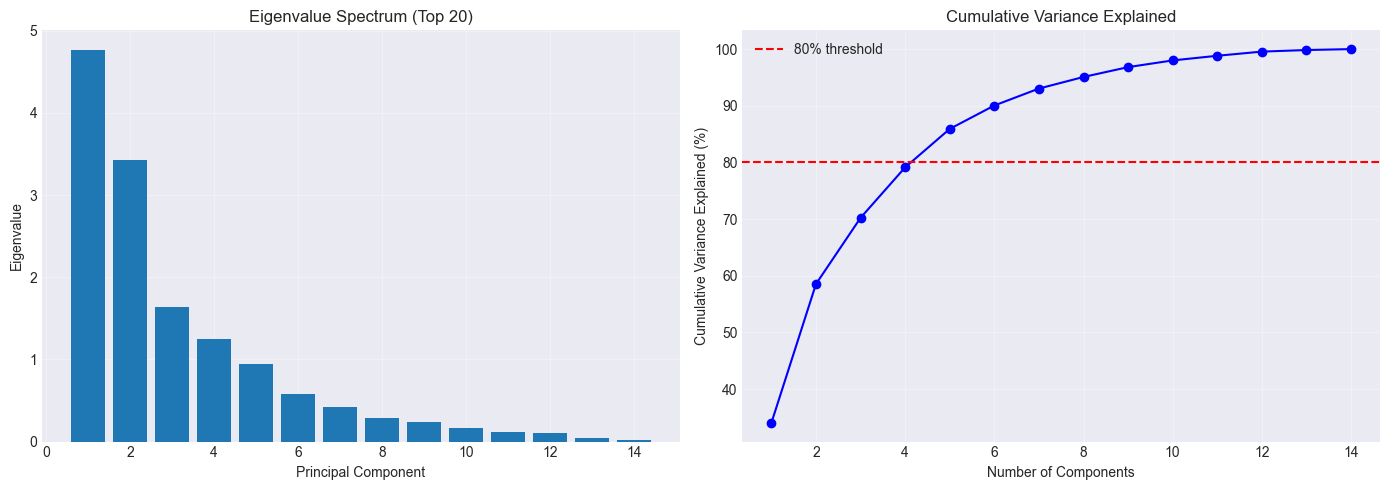

Number of components explaining 80% of variance: 5
Number of components explaining 90% of variance: 6
Number of components explaining 95% of variance: 8


In [12]:
# Eigenvalue decomposition of correlation matrix
eigenvalues, eigenvectors = np.linalg.eigh(correlation_matrix.values)
eigenvalues = eigenvalues[::-1]  # Sort in descending order
eigenvectors = eigenvectors[:, ::-1]

# Calculate variance explained
var_explained = eigenvalues / eigenvalues.sum()
cum_var_explained = np.cumsum(var_explained)

# Plot eigenvalue spectrum
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
ax1.bar(range(1, min(21, len(eigenvalues)+1)), eigenvalues[:20])
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Eigenvalue')
ax1.set_title('Eigenvalue Spectrum (Top 20)')
ax1.grid(True, alpha=0.3)

# Cumulative variance explained
ax2.plot(range(1, min(21, len(eigenvalues)+1)), cum_var_explained[:20] * 100, 'bo-')
ax2.axhline(y=80, color='r', linestyle='--', label='80% threshold')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Variance Explained (%)')
ax2.set_title('Cumulative Variance Explained')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Find number of components for 80% variance
n_components_80 = np.argmax(cum_var_explained >= 0.8) + 1
print(f"Number of components explaining 80% of variance: {n_components_80}")
print(f"Number of components explaining 90% of variance: {np.argmax(cum_var_explained >= 0.9) + 1}")
print(f"Number of components explaining 95% of variance: {np.argmax(cum_var_explained >= 0.95) + 1}")

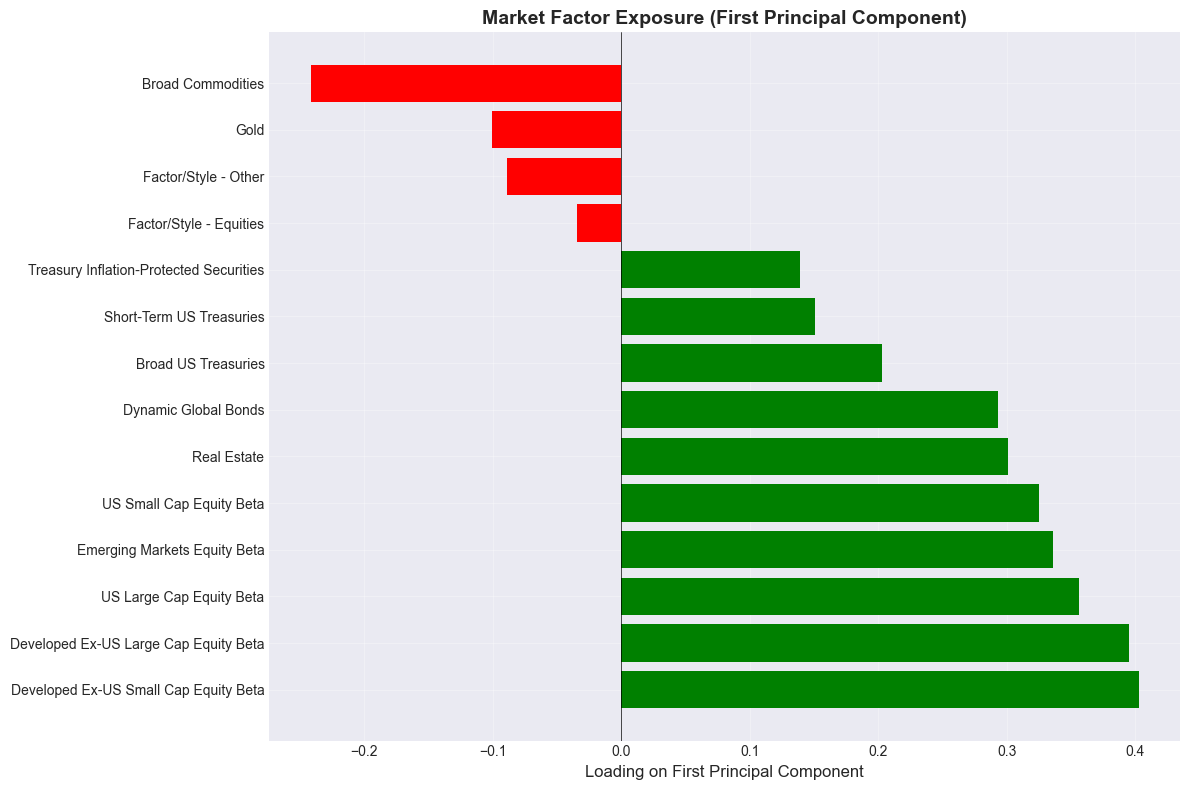

First principal component explains 34.0% of total variance


In [13]:
# Analyze first principal component
first_pc = eigenvectors[:, 0]
pc_loadings = pd.Series(first_pc, index=correlation_matrix.index).sort_values(ascending=False)

# Plot first principal component loadings
fig, ax = plt.subplots(figsize=(12, 8))

loadings_df = pd.DataFrame({
    'Exposure': [universe.get_exposure(exp).name for exp in pc_loadings.index],
    'Loading': pc_loadings.values
})

colors = ['green' if l > 0 else 'red' for l in loadings_df['Loading']]
bars = ax.barh(loadings_df['Exposure'], loadings_df['Loading'], color=colors)

ax.set_xlabel('Loading on First Principal Component', fontsize=12)
ax.set_title('Market Factor Exposure (First Principal Component)', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.5)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"First principal component explains {var_explained[0]:.1%} of total variance")

## 6. Risk-Based Clustering

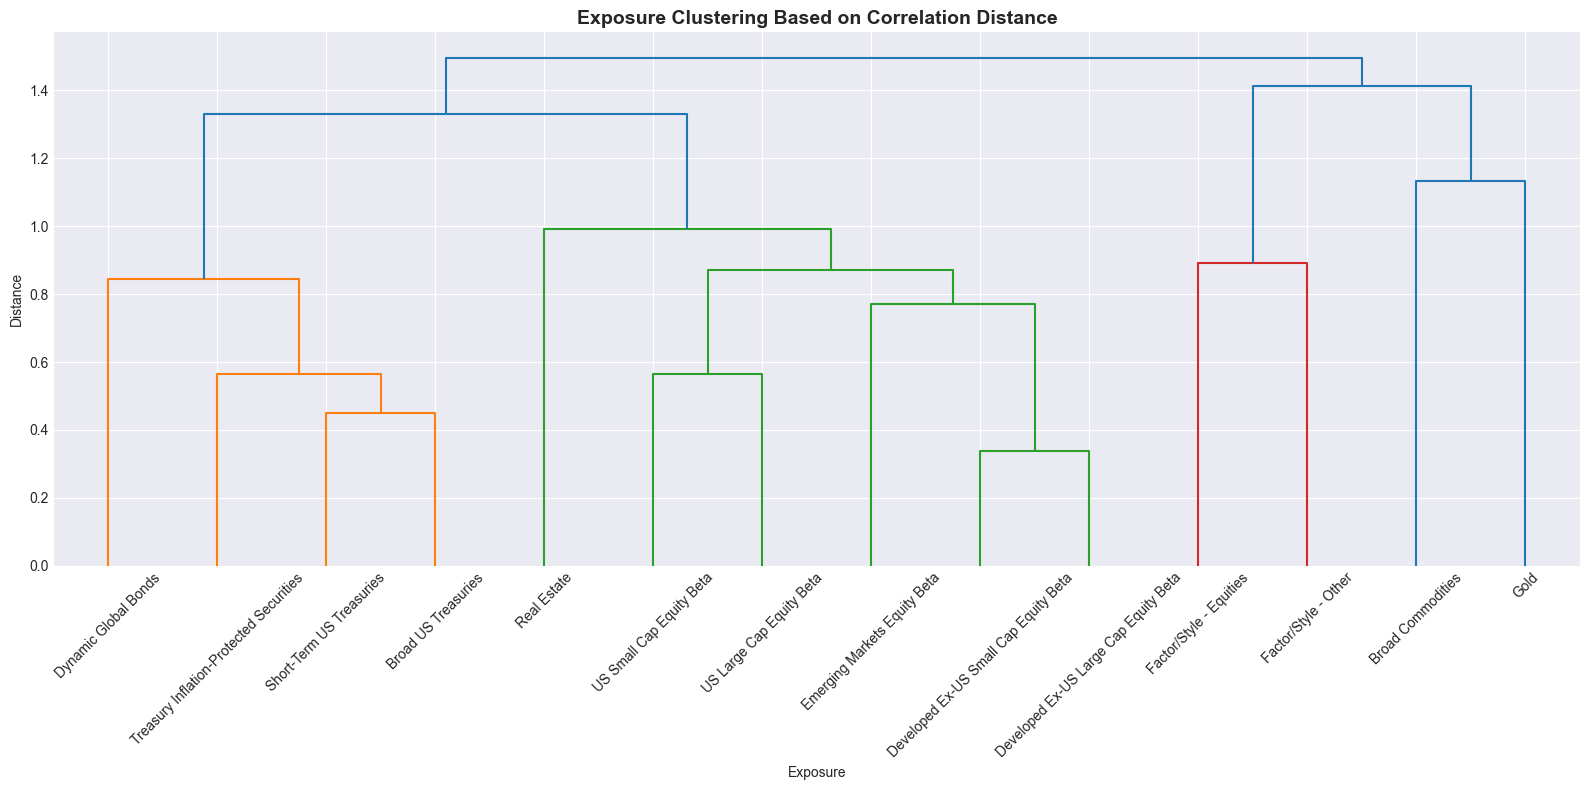

In [14]:
# Hierarchical clustering based on correlation distance
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

# Convert correlation to distance
distance_matrix = np.sqrt(2 * (1 - correlation_matrix.values))
condensed_dist = squareform(distance_matrix, checks=False)

# Perform hierarchical clustering
linkage_matrix = linkage(condensed_dist, method='average')

# Create dendrogram
plt.figure(figsize=(16, 8))
dendrogram(
    linkage_matrix,
    labels=labels,
    leaf_rotation=45,
    leaf_font_size=10
)
plt.title('Exposure Clustering Based on Correlation Distance', fontsize=14, fontweight='bold')
plt.xlabel('Exposure')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

## 7. Export Results

In [15]:
# Create results directory
results_dir = Path.cwd().parent / 'results' / 'risk_estimates'
results_dir.mkdir(parents=True, exist_ok=True)

# Export volatilities
vol_export = pd.DataFrame({
    'exposure_id': volatilities.index,
    'exposure_name': [universe.get_exposure(exp).name for exp in volatilities.index],
    'annualized_volatility': volatilities.values,
    'estimation_date': estimation_date,
    'forecast_horizon_days': forecast_horizon
})

vol_export.to_csv(results_dir / 'exposure_volatilities_1year.csv', index=False)
print(f"Saved volatilities to: {results_dir / 'exposure_volatilities_1year.csv'}")

# Export correlation matrix
correlation_matrix.to_csv(results_dir / 'exposure_correlations_1year.csv')
print(f"Saved correlations to: {results_dir / 'exposure_correlations_1year.csv'}")

# Export covariance matrix
risk_matrix.covariance_matrix.to_csv(results_dir / 'exposure_covariance_1year.csv')
print(f"Saved covariance to: {results_dir / 'exposure_covariance_1year.csv'}")

Saved volatilities to: /Users/scottmcguire/portfolio-tool/results/risk_estimates/exposure_volatilities_1year.csv
Saved correlations to: /Users/scottmcguire/portfolio-tool/results/risk_estimates/exposure_correlations_1year.csv
Saved covariance to: /Users/scottmcguire/portfolio-tool/results/risk_estimates/exposure_covariance_1year.csv


In [16]:
# Create summary report
summary = {
    'estimation_date': estimation_date.strftime('%Y-%m-%d'),
    'forecast_horizon_days': forecast_horizon,
    'number_of_exposures': len(risk_matrix.exposures),
    'estimation_method': risk_matrix.method,
    'lookback_days': lookback_days,
    'volatility_statistics': {
        'mean': volatilities.mean(),
        'median': volatilities.median(),
        'min': volatilities.min(),
        'max': volatilities.max(),
        'std': volatilities.std()
    },
    'correlation_statistics': {
        'mean': correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].mean(),
        'median': np.median(correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)]),
        'min': correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].min(),
        'max': correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].max()
    },
    'pca_analysis': {
        'components_for_80pct_variance': int(n_components_80),
        'first_component_variance_explained': float(var_explained[0]),
        'top_3_variance_explained': float(var_explained[:3].sum())
    }
}

# Save summary
import json
with open(results_dir / 'risk_estimation_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\nSaved summary to: {results_dir / 'risk_estimation_summary.json'}")
print("\nRisk Estimation Summary:")
print(json.dumps(summary, indent=2))


Saved summary to: /Users/scottmcguire/portfolio-tool/results/risk_estimates/risk_estimation_summary.json

Risk Estimation Summary:
{
  "estimation_date": "2025-07-07",
  "forecast_horizon_days": 252,
  "number_of_exposures": 14,
  "estimation_method": "optimal",
  "lookback_days": 1260,
  "volatility_statistics": {
    "mean": 0.10503067992773431,
    "median": 0.12060861932262312,
    "min": 0.013796764181046722,
    "max": 0.187056865675405,
    "std": 0.0592108062993385
  },
  "correlation_statistics": {
    "mean": 0.1356069454732157,
    "median": 0.029458840981681073,
    "min": -0.45259187711981436,
    "max": 0.9428230675669659
  },
  "pca_analysis": {
    "components_for_80pct_variance": 5,
    "first_component_variance_explained": 0.3404867662119558,
    "top_3_variance_explained": 0.7023326563430875
  }
}


## 8. Portfolio Construction Example

Example of how to use these risk estimates for portfolio optimization:

In [17]:
# Example: Create equal-risk contribution portfolio using the risk estimates
from optimization.methods import RiskParityOptimizer

# Select a subset of exposures for the example
portfolio_exposures = [
    'us_large_equity',
    'intl_developed_large_equity', 
    'us_treasury_long',
    'commodities_broad'
]

# Filter available exposures
available_portfolio_exp = [exp for exp in portfolio_exposures if exp in risk_matrix.exposures]

if len(available_portfolio_exp) >= 2:
    # Extract covariance for selected exposures
    exp_indices = [risk_matrix.exposures.index(exp) for exp in available_portfolio_exp]
    portfolio_cov = risk_matrix.covariance_matrix.iloc[exp_indices, exp_indices]
    
    print("Example Portfolio Exposures:")
    for exp in available_portfolio_exp:
        vol = risk_matrix.volatilities[exp]
        print(f"  {universe.get_exposure(exp).name}: {vol:.2%} volatility")
    
    print("\nThis covariance matrix can now be used with the portfolio optimization engine.")
    print(f"\nCovariance matrix shape: {portfolio_cov.shape}")
    print("\nReady for optimization!")
else:
    print("Not enough exposures available for portfolio example.")

Example Portfolio Exposures:
  US Large Cap Equity Beta: 12.71% volatility
  Developed Ex-US Large Cap Equity Beta: 12.11% volatility

This covariance matrix can now be used with the portfolio optimization engine.

Covariance matrix shape: (2, 2)

Ready for optimization!


## Conclusion

This notebook has generated comprehensive one-year risk estimates for all exposures in the universe:

1. **Volatility Forecasts**: Forward-looking volatility estimates using validated parameters
2. **Correlation Structure**: Complete correlation matrix showing relationships between exposures
3. **Risk Decomposition**: Principal component analysis showing main risk factors
4. **Clustering Analysis**: Grouping of similar exposures based on correlation
5. **Export Files**: All results saved for use in portfolio optimization

The risk estimates are now ready to be used with the portfolio optimization engine to construct optimal portfolios based on forward-looking risk estimates.